# Pruebas Tipos de Ruido y Mecanismos de Votación

## Función para pasar a 2d y hacer plot

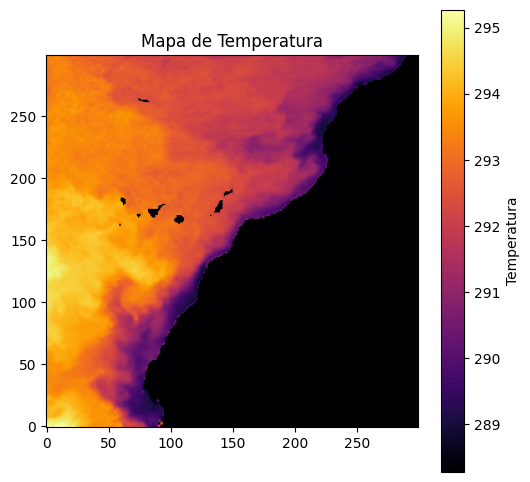

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def flatten_to_2d(datos, mask, shape=(300, 300)):
    """
    Convierte un array 1D de datos en una matriz 2D usando una máscara.

    :param datos: Array de datos en formato 1D.
    :param mask: Máscara binaria en formato 1D.
    :param shape: Dimensiones de salida de la matriz 2D.
    :return: Matriz 2D con los valores de `datos` ubicados según `mask`.
    """
    mask = mask.flatten()
    temperature_map = np.zeros_like(mask, dtype=float)

    j = 0
    for i in range(len(mask)):
        if mask[i] == 1:
            temperature_map[i] = datos[j]
            j += 1

    return temperature_map.reshape(shape)

def plot_temperature_map(temperature_map, cmap="inferno"):
    """
    Genera y muestra un mapa de temperatura, ignorando valores NaN en la normalización.

    :param temperature_map: Matriz 2D con los datos a visualizar.
    :param cmap: Colormap para la visualización.
    """
    plt.figure(figsize=(6, 6))

    norm = Normalize(vmin=np.nanmin(temperature_map), vmax=np.nanmax(temperature_map))
    plt.imshow(temperature_map, cmap=cmap, origin='lower', norm=norm)

    plt.colorbar(label="Temperatura")
    plt.title("Mapa de Temperatura")
    plt.show()

## Implementaciones ruidos

### Rudio Gaussiano y clase Base

El ruido añadido sigue una distribución normal, se puede indicar la media y desviación estándar de la distribución.

**Se usa en**:
- Gencast (sobre ERA 5 analysis)

In [38]:
class Noise:
    def apply(self, data):
        pass

class GaussianNoise(Noise):
    def __init__(self, mean=0, std=1):
        self.mean = mean
        self.std = std

    def apply(self, data):
        
        noisy_data = data + np.random.normal(self.mean, self.std, data.shape)
        noisy_data[noisy_data < 1] = 0

        return noisy_data

### Ruido Perlin

El rudio Perlin es un algoritmo generalmente usado para la creación procedimental de contenido (por ejemplo geneación de terreno en juegos). Se puede generalmente generar en 2 y 3 dimensiones. El algoritmo tienes tres etapas:

- Definición de grid de vectores de gradiente aleatorios.
- Producto escalar entre los vectores de los gradiente y sus desplazamientos.
- Interpolación de valores.

Los argumentos son: 

- Shape del array de datos.
- Resolución: número de períodos de ruido a generar para cada dimensión.
- Tileable: si el rudio debe seguir una transción en algún eje.

**Se usa en**:
- Fuxi

In [39]:
from perlin_numpy import (
    generate_fractal_noise_2d, generate_fractal_noise_3d,
    generate_perlin_noise_2d, generate_perlin_noise_3d
)

class PerlinNoise(Noise):
    def __init__(self, resolution=(2, 12, 12)):
        self.resolution = resolution

    def apply(self, data, mask):

        data_2d_list = []

        for entry in data:

            data_2d = flatten_to_2d(entry, mask) 
            data_2d_list.append(data_2d)

        data_2d_array = np.array(data_2d_list)

        noise = generate_perlin_noise_3d(
            shape=(data_2d_array.shape[0], data_2d_array.shape[1], data_2d_array.shape[2]), res=self.resolution, tileable=(True, False, False)
        )

        noisy_data_list = []             

        for i in range(len(data_2d_array)):

            #Para generación 2D, habría que cambiar seed para poder aleatorizar el ruido
            #noise = generate_perlin_noise_2d(data_2d_array[i].shape, (10, 10))

            noise_entry = noise[i]
            entry = data_2d_array[i]

            noisy_data = entry + noise_entry
            
            noisy_data_flat = noisy_data.flatten()
            noisy_data_flat = noisy_data_flat[noisy_data_flat >= 1]

            noisy_data_list.append(noisy_data_flat)

        return noisy_data_list

### Ruido Perlin Fractal

El rudio Perlin es un algoritmo generalmente usado para la creación procedimental de contenido (por ejemplo geneación de terreno en juegos). Se puede generalmente generar en 2 y 3 dimensiones. El algoritmo tienes tres etapas:

- Definición de grid de vectores de gradiente aleatorios.
- Producto escalar entre los vectores de los gradiente y sus desplazamientos.
- Interpolación de valores.

La diferencia con Perlin original es que tenemos el concepto de octavas, que podría ser visto como iteraciones sobre el ruido donde se agregan detalles más finos.  Los argumentos son similares, pero se agrega persistencia (factor de escalado entre dos octavas), y las propias octavas.

**Se usa en**:
- Fuxi con 3 octavas

In [40]:
class PerlinNoiseFractal:
    def __init__(self, resolution=(1, 3, 3), persistence=0.5, octaves=1):
        self.resolution = resolution
        self.persistence = persistence
        self.octaves = octaves

    def apply(self, data, mask):

        data_2d_list = []

        for entry in data:

            data_2d = flatten_to_2d(entry, mask) 
            data_2d_list.append(data_2d)

        data_2d_array = np.array(data_2d_list)

        noise = generate_fractal_noise_3d(
            shape=(data_2d_array.shape[0], data_2d_array.shape[1], data_2d_array.shape[2]), tileable=(True, False, False), res=self.resolution, persistence=self.persistence, octaves=self.octaves
        )

        print("noise.shape", noise.shape)
        print("data_2d_array.shape", data_2d_array.shape)

        noisy_data_list = []             

        for i in range(len(data_2d_array)):

            #Para generación 2D, habría que cambiar seed para poder aleatorizar el ruido
            #noise = generate_perlin_noise_2d(data_2d_array[i].shape, (10, 10))

            noise_entry = noise[i]
            entry = data_2d_array[i]

            noisy_data = entry + noise_entry
            
            noisy_data_flat = noisy_data.flatten()
            noisy_data_flat = noisy_data_flat[noisy_data_flat >= 1]

            noisy_data_list.append(noisy_data_flat)

        return noisy_data_list   

### Ruido Simplex

El autor de Perlin Noise, Ken Perlin, creo una mejora o actualización llamada Simplex Noise. Alguno de los problemas que resuelve son:

- Menor coste computacional, especialmente al trabajar con dimensiones mayores.
- Reduce la presencia de patrones reconocibles.

No se usa en ningún estudio encontrado, pero al estar relacionado y ser una mejora de perlín tal vez sería interesante.

https://www.researchgate.net/publication/216813608_Simplex_noise_demystified

In [41]:
from opensimplex import noise2, noise3
import numpy as np
import opensimplex

class SimplexNoise:
    def __init__(self, feature_size=24.0):
        self.feature_size = feature_size

    def apply(self, data, mask):
        noisy_data_list = []

        for i, entry in enumerate(data):
            #tmp = OpenSimplex(seed=self.base_seed + i)  # Semilla distinta por muestra
            data_2d = flatten_to_2d(entry, mask)
            height, width = data_2d.shape
            noisy_data = np.zeros_like(data_2d)

            for y in range(height):
                for x in range(width):
                    #se puede usar también noise2 + seed
                    value = noise3(x / self.feature_size, y / self.feature_size, i)
                    noise_val = (value + 1) / 2
                    noisy_data[y, x] = data_2d[y, x] + noise_val

            noisy_data_flat = noisy_data.flatten()
            noisy_data_flat = noisy_data_flat[noisy_data_flat >= 1]

            noisy_data_list.append(noisy_data_flat)

        return noisy_data_list


## Otras estrategias

### Lagged Forecast

Es una ténica mencionada sobre todo en modelos Númericos documentados por ECMWF. Consiste en que cada modelos comienza a predecir en distintos instantes de tiempo (ensemble rezagado), aunque también se menciona en un artículo de machine learning:

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2024GL113656

shape datos_concatenados (12, 49061, 1)
shape datos_concatenados_sliced_window (10, 49061, 1)
shape datos_concatenados_sliced_window_2 (8, 49061, 1)
shape predict_ens_1 (49061, 1)
shape predict_ens_2 (49061, 1)
shape predict_ens_3 (49061, 1)
shape ens_result (49061, 1)


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_1712\500886969.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temperature_map[i] = datos[j]


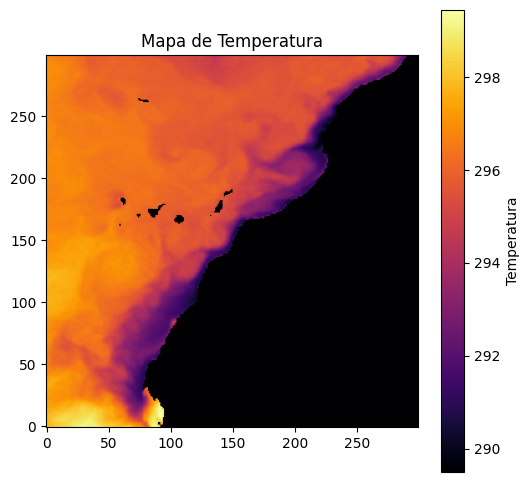

shape predict_ens_1 (49061, 1)
shape predict_ens_2 (49061, 1)
shape predict_ens_3 (49061, 1)
shape ens_result (49061, 1)


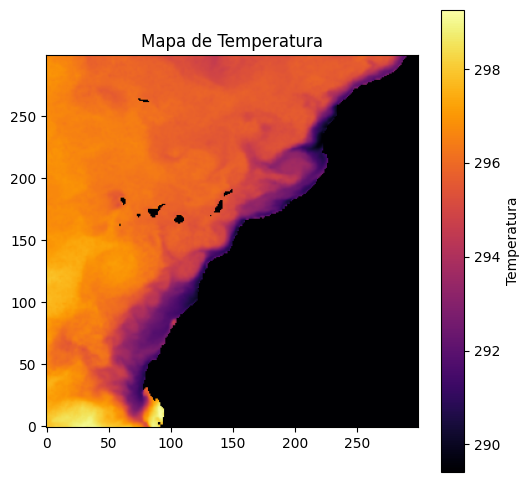

shape predict_ens_1 (49061, 1)
shape predict_ens_2 (49061, 1)
shape predict_ens_3 (49061, 1)
shape ens_result (49061, 1)


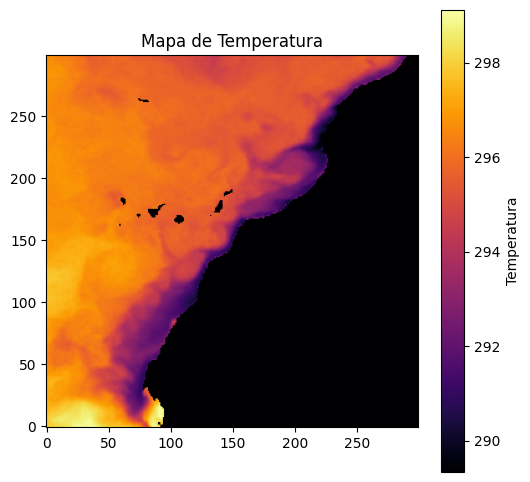

shape predict_ens_1 (49061, 1)
shape predict_ens_2 (49061, 1)
shape predict_ens_3 (49061, 1)
shape ens_result (49061, 1)


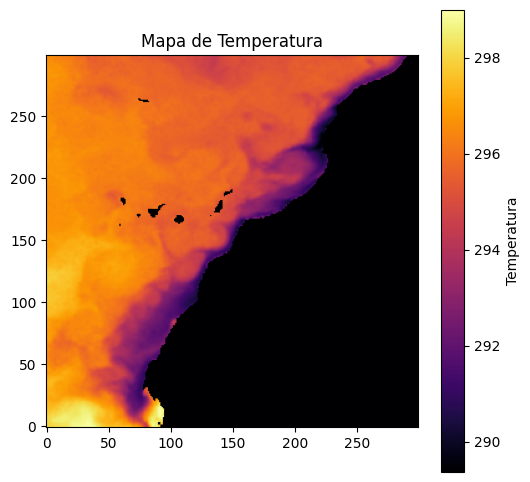

In [42]:
### Lagged Forecast
archivo = r"..\data\atlantic\samples\train\rea_data_20191014.npy"
archivo_2 = r"..\data\atlantic\samples\train\rea_data_20191021.npy"
datos = np.load(archivo)
datos_2 = np.load(archivo_2)

datos_concatenados = np.concatenate((datos, datos_2), axis=0)
datos_concatenados_sliced_window = datos_concatenados[2:,:,:]
datos_concatenados_sliced_window_2 = datos_concatenados[4:,:,:]

print("shape datos_concatenados", datos_concatenados.shape)
print("shape datos_concatenados_sliced_window", datos_concatenados_sliced_window.shape)
print("shape datos_concatenados_sliced_window_2", datos_concatenados_sliced_window_2.shape)

def predict(t):
    return t

for entry in range(4, len(datos_concatenados_sliced_window_2)):
    predict_ens_1 = predict(datos_concatenados[entry])
    predict_ens_2 = predict(datos_concatenados_sliced_window[entry])
    predict_ens_3 = predict(datos_concatenados_sliced_window_2[entry])

    print("shape predict_ens_1", predict_ens_1.shape)
    print("shape predict_ens_2", predict_ens_2.shape)
    print("shape predict_ens_3", predict_ens_3.shape)

    ens_result = np.mean([predict_ens_1, predict_ens_2, predict_ens_3], axis=0)
    print("shape ens_result", ens_result.shape)

    ens_result_2d = flatten_to_2d(ens_result, mask)

    plot_temperature_map(ens_result_2d, cmap="inferno")



### Posibles estrategias:

- Técnica difusión GenCast

Se parte de ruido puro y con un proceso de denoising se llega a una nueva muestra. Se parte de una distribución de ruido Gaussiano en una esfera. Se tiene un modelo que permite eliminar ruido aprendiendo de muestras.

- Vectores singulares

Se encontró en uso en el artículo, aunque nuevamente dnde más se menciona es en modelos númericos de ECMWF. En este caso, se calculan la descomposición en valores singulares de desde la matriz jacobiana de la red neuronal (derivadas parciales de la salida respecto a su entrada o parámetros).

https://arxiv.org/pdf/2002.05398v1

- Perturbaciones estocásticas

Se mencionan también sobre todo en modelos númericos de ECMWF.

- Diferentes Checkpoints de inicialización

No se ha encontrado en caso de predicción climática, pero el modelo Bert fue usado partiendo de distintos puntos de inicialización. 

- Ruido para condiciones externas

## Pruebas ruidos

### Ruido Gaussiano

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_1712\500886969.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temperature_map[i] = datos[j]


Datos originales:


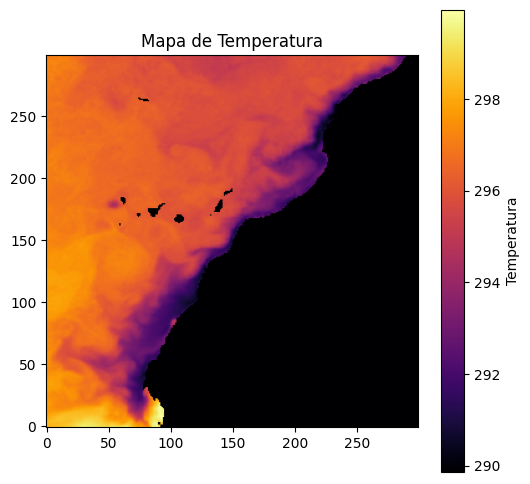

Datos con ruido:


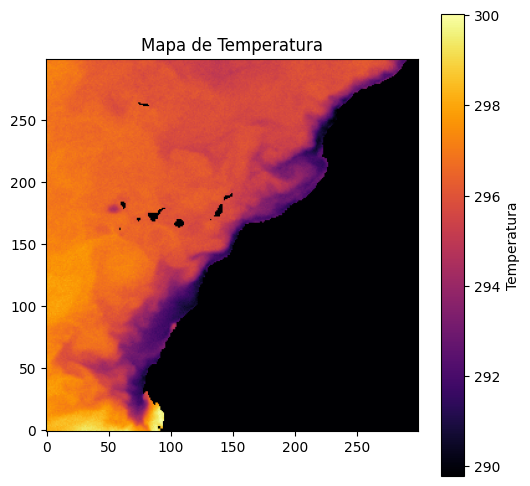

Diferencia:


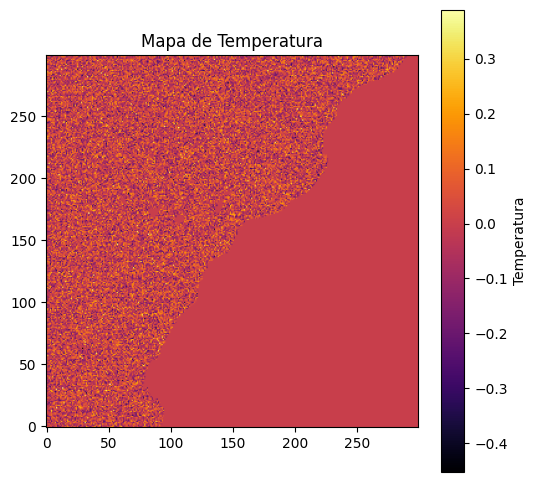

Datos originales:


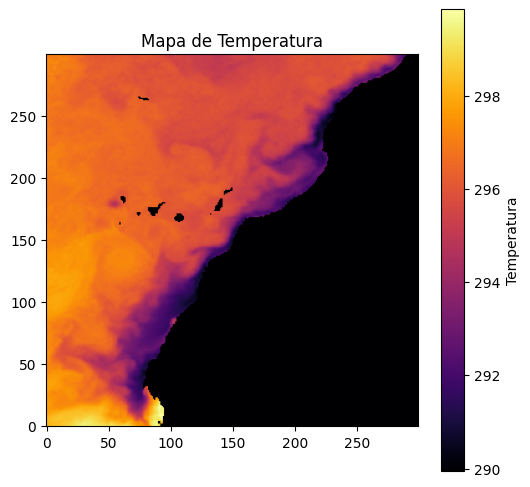

Datos con ruido:


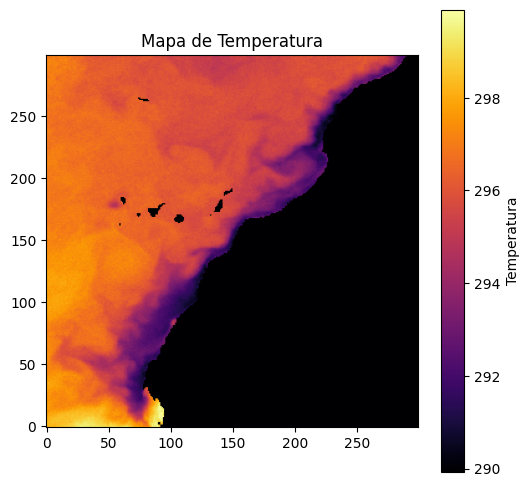

Diferencia:


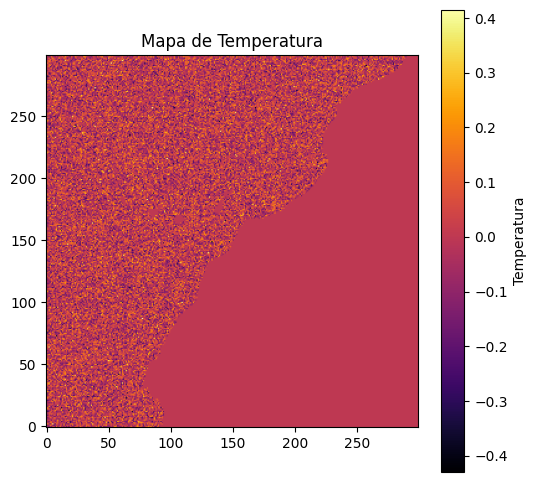

In [43]:
archivo = r"..\data\atlantic\samples\train\rea_data_20191014.npy"
datos = np.load(archivo)

mean = 0
std = 0.1

gaussian_noise = GaussianNoise(mean, std)

noisy_data = gaussian_noise.apply(datos[:2])

gaussian_noise_list = noisy_data.copy()

for i in range(len(noisy_data[:2])):

    current_data_noise = noisy_data[i]

    current_data_2d = flatten_to_2d(datos[i], mask)

    current_data_noise_2d = flatten_to_2d(current_data_noise, mask)

    print("Datos originales:")
    plot_temperature_map(current_data_2d)

    print("Datos con ruido:")
    plot_temperature_map(current_data_noise_2d)

    diff = current_data_noise_2d - current_data_2d

    print("Diferencia:")
    plot_temperature_map(diff)

### Ruido Perlin

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_1712\500886969.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temperature_map[i] = datos[j]


(2, 49061)
-0.0026332153776113237
Datos originales:


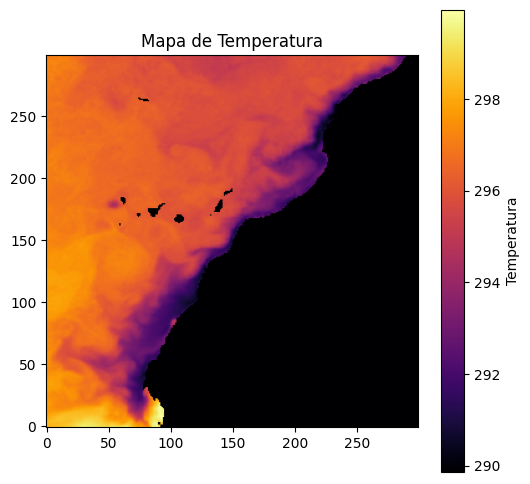

Datos con ruido:


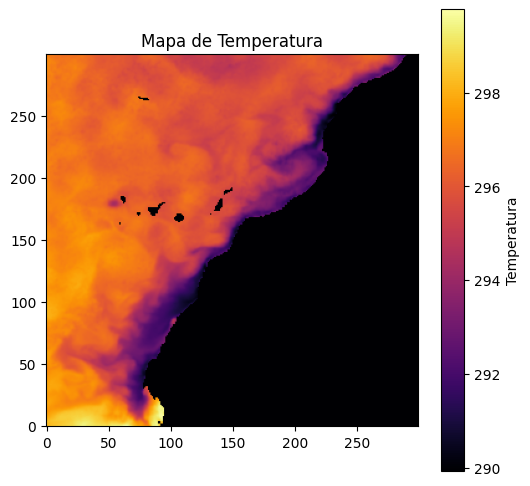

Diferencia:


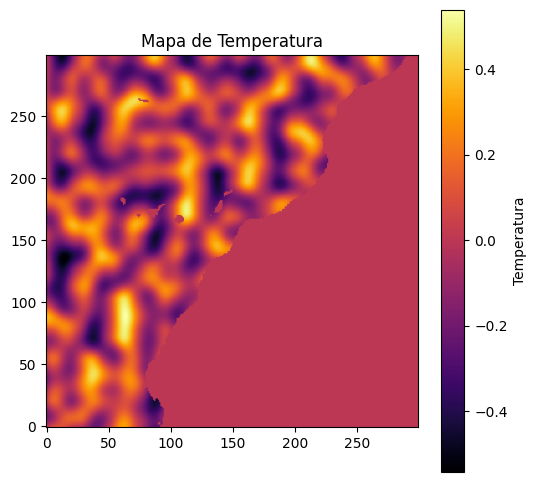

(2, 49061)
-0.0008908712160708439
Datos originales:


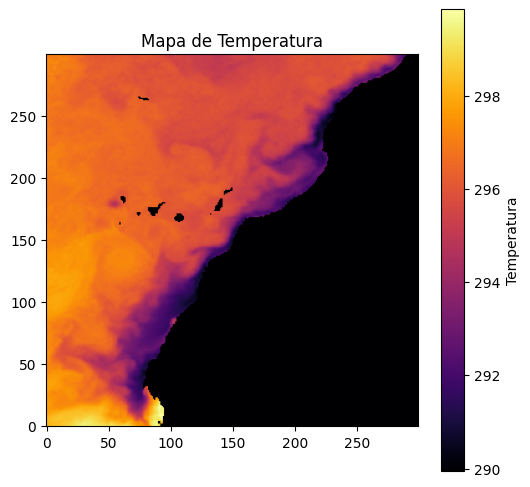

Datos con ruido:


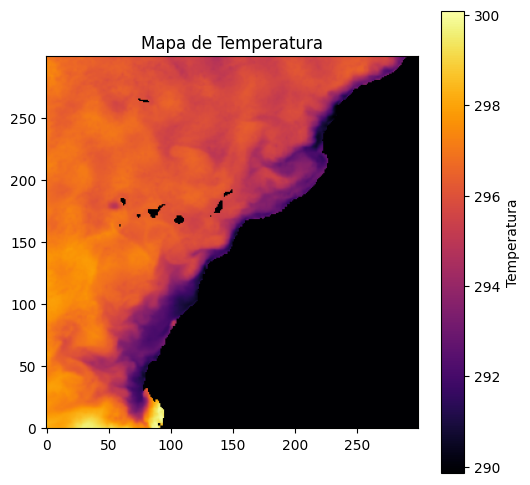

Diferencia:


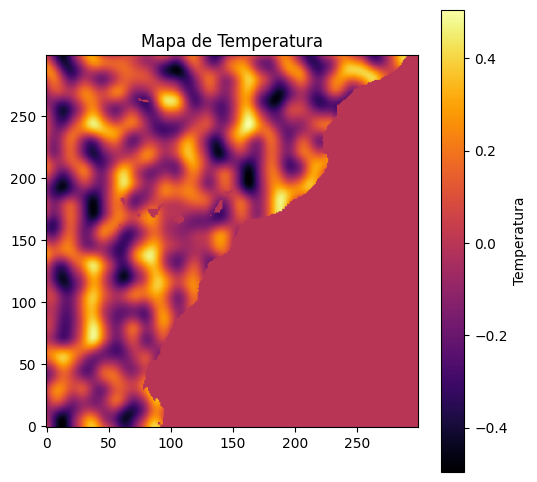

In [56]:
archivo = r"..\data\atlantic\samples\train\rea_data_20191014.npy"
datos = np.load(archivo)

perlin_noise = PerlinNoise(resolution=(2, 12, 12))

perlin_noise_list = perlin_noise.apply(datos[:2, :, :], mask)

for i in range(len(perlin_noise_list)):

    perlin_noise_list_array = np.array(perlin_noise_list)

    print(perlin_noise_list_array.shape)

    current_data = datos[i]
    noisy_data= perlin_noise_list[i]

    current_data_2d = flatten_to_2d(current_data, mask)
    noisy_data_2d = flatten_to_2d(noisy_data, mask)

    diff = noisy_data_2d - current_data_2d

    print(np.mean(diff))

    print("Datos originales:")
    plot_temperature_map(current_data_2d)

    print("Datos con ruido:")
    plot_temperature_map(noisy_data_2d)

    print("Diferencia:")
    plot_temperature_map(diff)

### Rudio Perlin Fractal

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_1712\500886969.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temperature_map[i] = datos[j]


noise.shape (2, 300, 300)
data_2d_array.shape (2, 300, 300)
0.017510924452412972
Datos originales:


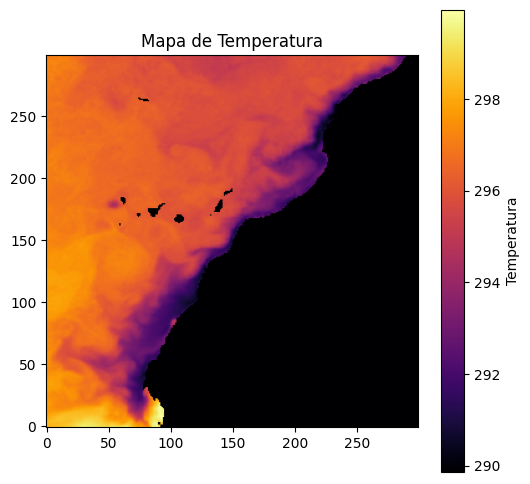

Datos con ruido:


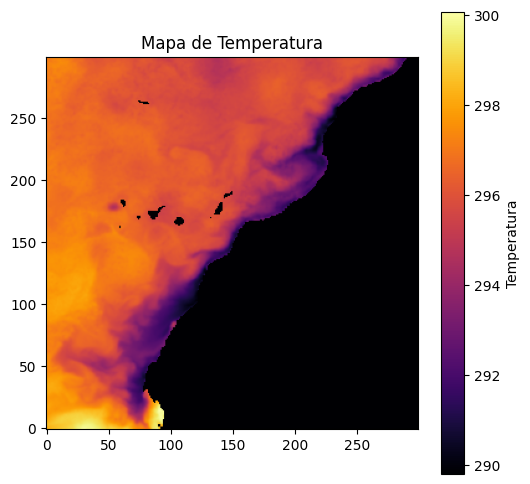

Diferencia:


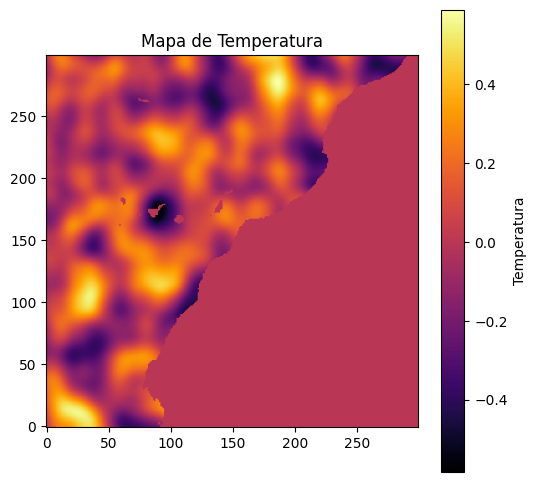

0.01649768591351367
Datos originales:


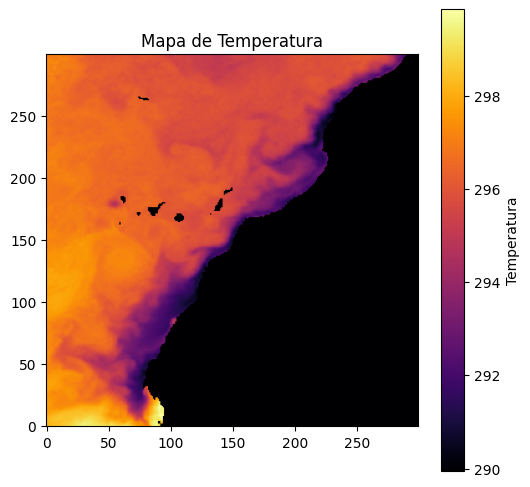

Datos con ruido:


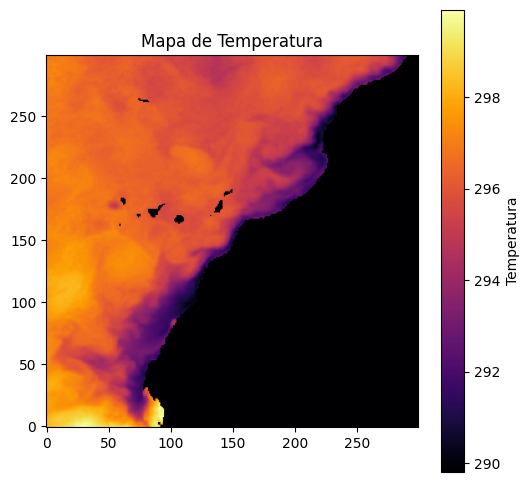

Diferencia:


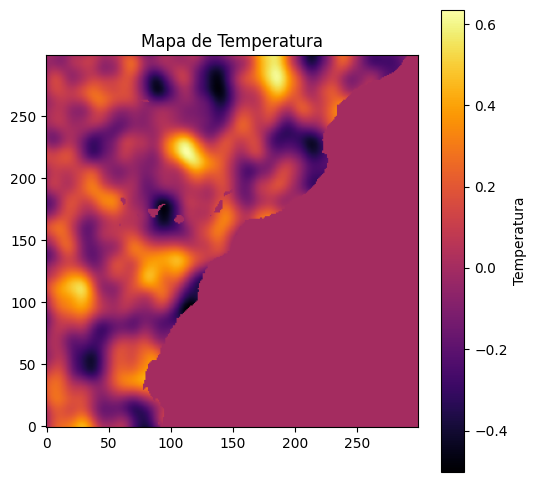

In [46]:
archivo = r"..\data\atlantic\samples\train\rea_data_20191014.npy"
datos = np.load(archivo)

perlin_noise_fractal = PerlinNoiseFractal(resolution=(1, 6, 6), octaves=2)

perlin_noise_fractal_list = perlin_noise_fractal.apply(datos[:2, :, :], mask)

for i in range(len(perlin_noise_fractal_list)):

    perlin_noise_fractal_list_array = np.array(perlin_noise_fractal_list)

    current_data = datos[i]
    noisy_data= perlin_noise_fractal_list[i]

    current_data_2d = flatten_to_2d(current_data, mask)
    noisy_data_2d = flatten_to_2d(noisy_data, mask)

    diff = noisy_data_2d - current_data_2d

    print(np.mean(diff))

    print("Datos originales:")
    plot_temperature_map(current_data_2d)

    print("Datos con ruido:")
    plot_temperature_map(noisy_data_2d)

    print("Diferencia:")
    plot_temperature_map(diff)

### Simplex Noise

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_1712\500886969.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temperature_map[i] = datos[j]


0.2681520341817022


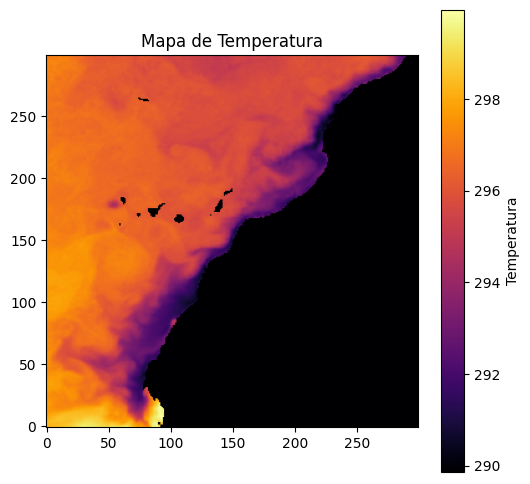

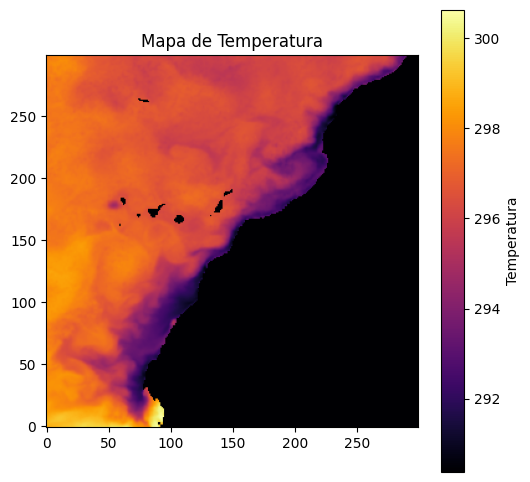

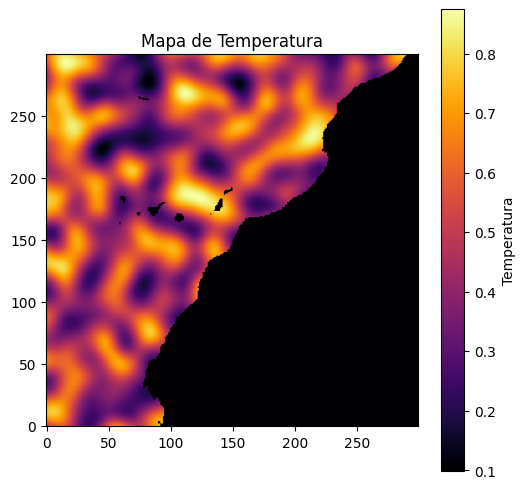

0.26738527941492884


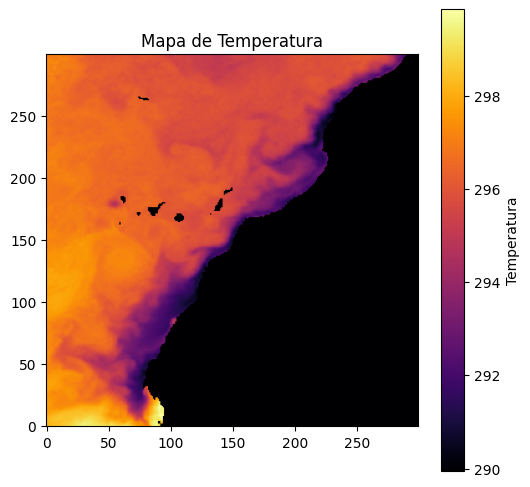

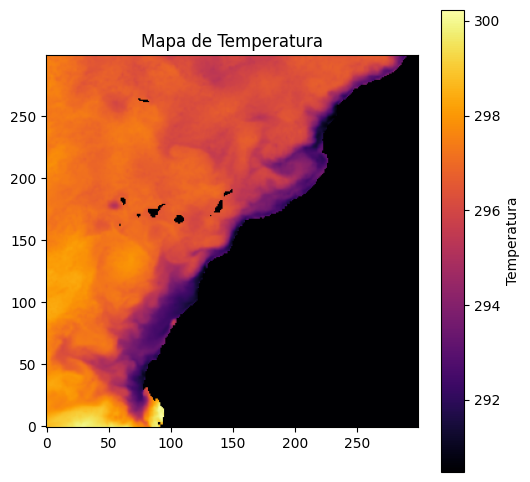

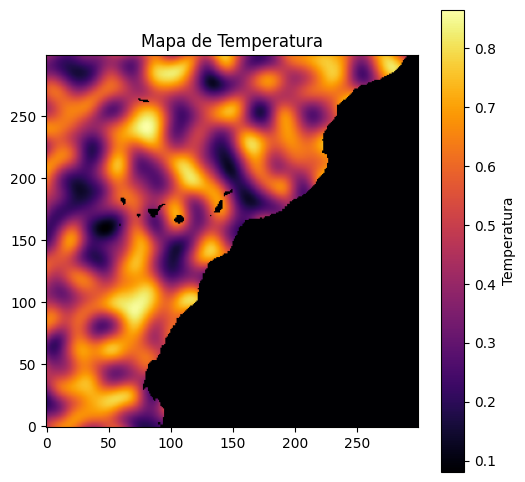

In [47]:
archivo = r"..\data\atlantic\samples\train\rea_data_20191014.npy"
datos = np.load(archivo)

simplex_noise = SimplexNoise()

simplex_noise_data = simplex_noise.apply(datos[:2, :, :], mask=mask)

simplex_noise_list = []

for i in range(len(simplex_noise_data)):
    
    simplex_data = simplex_noise_data[i]

    current_data = datos[i]

    current_data_2d = flatten_to_2d(current_data, mask)

    noisy_data_2d = flatten_to_2d(simplex_data, mask)

    diff = noisy_data_2d - current_data_2d

    print(np.mean(diff))

    plot_temperature_map(current_data_2d)

    plot_temperature_map(noisy_data_2d)

    plot_temperature_map(diff)

    simplex_noise_list.append(simplex_data)


## Comparación ruidos

### Histogramas

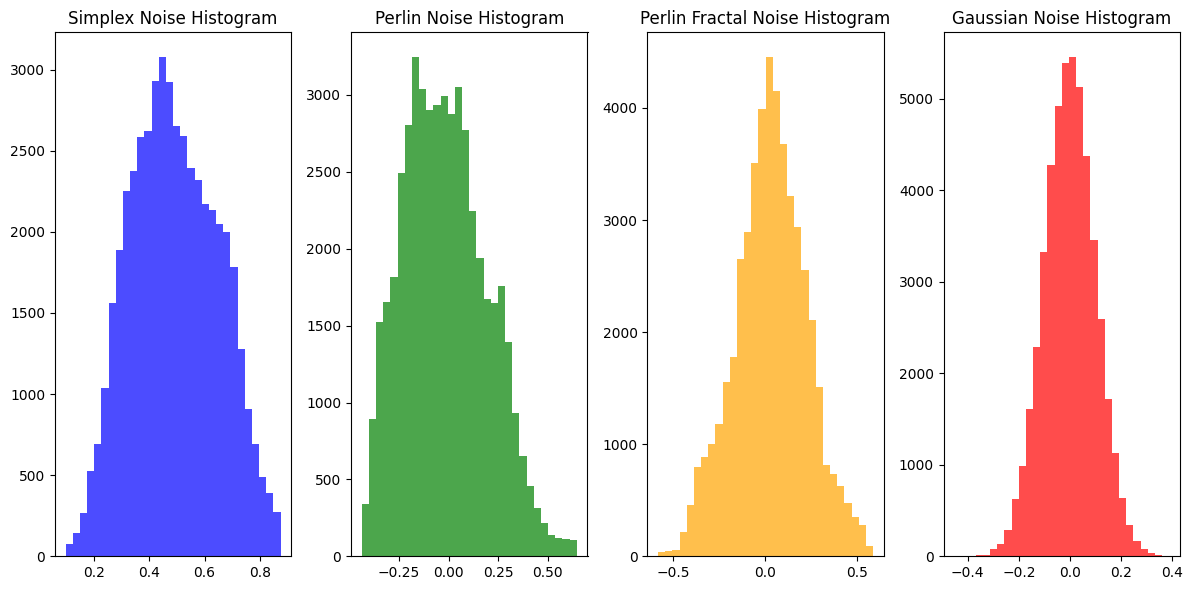

In [48]:
import matplotlib.pyplot as plt

# Asumiendo que cada lista contiene muestras 2D de ruido
def plot_histograms(simplex_data, perlin_data, gaussian_data, perlin_data_fractal, original_data):

    simplex_data_nonzero = simplex_data - original_data
    simplex_data_nonzero = simplex_data_nonzero[simplex_data_nonzero != 0]

    perlin_data_nonzero = perlin_data - original_data
    perlin_data_nonzero = perlin_data_nonzero[perlin_data_nonzero != 0]

    gaussian_data_nonzero = gaussian_data - original_data
    gaussian_data_nonzero = gaussian_data_nonzero[gaussian_data_nonzero != 0]

    perlin_data_fractal_nonzero = perlin_data_fractal - original_data
    perlin_data_fractal_nonzero = perlin_data_fractal_nonzero[perlin_data_fractal_nonzero != 0]

    plt.figure(figsize=(12, 6))
    
    plt.subplot(141)
    plt.hist(simplex_data_nonzero, bins=30, color='blue', alpha=0.7)
    plt.title('Simplex Noise Histogram')
    
    plt.subplot(142)
    plt.hist(perlin_data_nonzero, bins=30, color='green', alpha=0.7)
    plt.title('Perlin Noise Histogram')

    plt.subplot(143)
    plt.hist(perlin_data_fractal_nonzero, bins=30, color='orange', alpha=0.7)
    plt.title('Perlin Fractal Noise Histogram')
    
    plt.subplot(144)
    plt.hist(gaussian_data_nonzero, bins=30, color='red', alpha=0.7)
    plt.title('Gaussian Noise Histogram')


    
    plt.tight_layout()
    plt.show()

plot_histograms(simplex_noise_list[0], perlin_noise_list[0], np.squeeze(gaussian_noise_list[0]), perlin_noise_fractal_list[0], np.squeeze(datos[0]))

### Boxplots

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_1712\4159617903.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Simplex', 'Perlin', 'Gaussian', 'Perlin Fractal'])


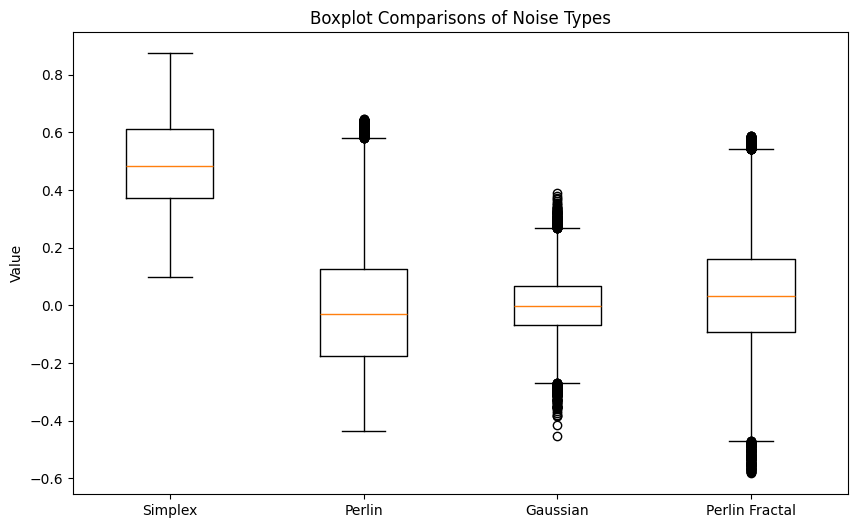

In [49]:
def plot_boxplots(simplex_data, perlin_data, gaussian_data, perlin_data_fractal, original_data):

    original_data = flatten_to_2d(original_data, mask)

    plt.figure(figsize=(10, 6))

    simplex_data = flatten_to_2d(simplex_data, mask)
    perlin_data = flatten_to_2d(perlin_data, mask)
    gaussian_data = flatten_to_2d(gaussian_data, mask)
    perlin_data_fractal = flatten_to_2d(perlin_data_fractal, mask)

    simplex_data_nonzero = simplex_data - original_data
    simplex_data_nonzero = simplex_data_nonzero[simplex_data_nonzero != 0]

    perlin_data_nonzero = perlin_data - original_data
    perlin_data_nonzero = perlin_data_nonzero[perlin_data_nonzero != 0]

    gaussian_data_nonzero = gaussian_data - original_data
    gaussian_data_nonzero = gaussian_data_nonzero[gaussian_data_nonzero != 0]

    perlin_data_fractal_nonzero = perlin_data_fractal - original_data
    perlin_data_fractal_nonzero = perlin_data_fractal_nonzero[perlin_data_fractal_nonzero != 0]

    data = [simplex_data_nonzero.flatten(), perlin_data_nonzero.flatten(), gaussian_data_nonzero.flatten(), perlin_data_fractal_nonzero.flatten()]
    plt.boxplot(data, labels=['Simplex', 'Perlin', 'Gaussian', 'Perlin Fractal'])
    
    plt.title('Boxplot Comparisons of Noise Types')
    plt.ylabel('Value')
    plt.show()

# Llamada a la función
plot_boxplots(simplex_noise_list[0], perlin_noise_list[0], np.squeeze(gaussian_noise_list[0]), perlin_noise_fractal_list[0], np.squeeze(datos[0]))

### Vista en mapa

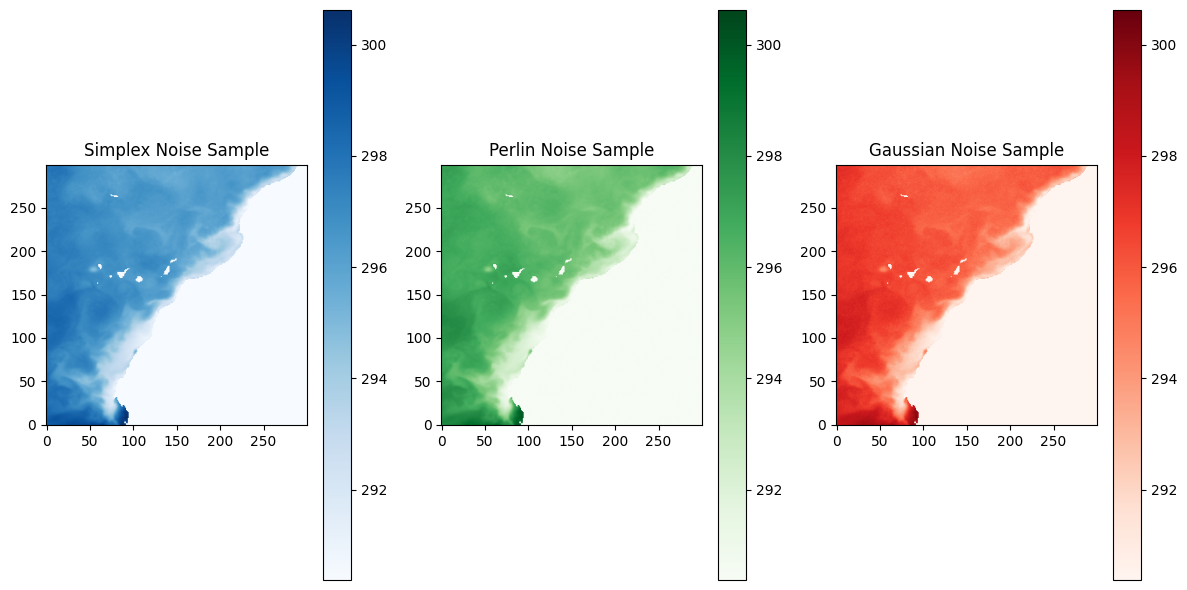

In [50]:
def plot_2d_samples(simplex_data, perlin_data, gaussian_data):
    plt.figure(figsize=(12, 6))

    #normalizar graficas

    simplex_data = flatten_to_2d(simplex_data, mask)
    perlin_data = flatten_to_2d(perlin_data, mask)
    gaussian_data = flatten_to_2d(gaussian_data, mask)

    norm = Normalize(vmin=np.min(simplex_data[simplex_data != 0]), vmax=np.max(simplex_data))
    
    plt.subplot(131)
    plt.imshow(simplex_data, cmap='Blues', norm=norm, origin='lower')
    plt.title('Simplex Noise Sample')
    plt.colorbar()
    
    plt.subplot(132)
    plt.imshow(perlin_data, cmap='Greens', norm=norm, origin='lower')
    plt.title('Perlin Noise Sample')
    plt.colorbar()
    
    plt.subplot(133)
    plt.imshow(gaussian_data, cmap='Reds', norm=norm, origin='lower')
    plt.title('Gaussian Noise Sample')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

# Llamada a la función
plot_2d_samples(simplex_noise_list[0], perlin_noise_list[0], np.squeeze(gaussian_noise_list[0]))

### Diferencias respecto a datos originales

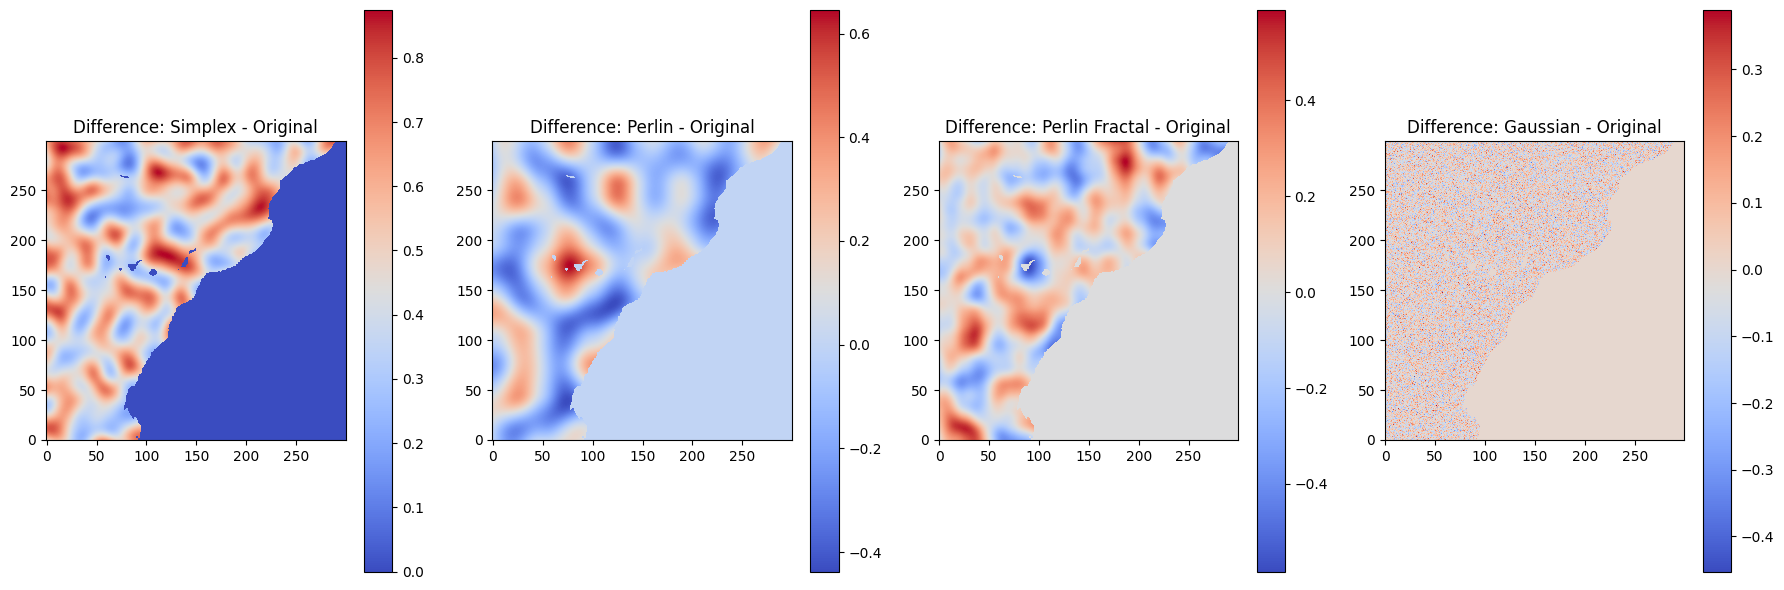

In [51]:
def plot_differences(simplex_data, perlin_data, gaussian_data, perlin_data_fractal, original_data):

    original_data = flatten_to_2d(original_data, mask)
    simplex_data = flatten_to_2d(simplex_data, mask)
    perlin_data = flatten_to_2d(perlin_data, mask)
    gaussian_data = flatten_to_2d(gaussian_data, mask)
    perlin_data_fractal = flatten_to_2d(perlin_data_fractal, mask)

    diff_simplex = simplex_data - original_data
    diff_perlin = perlin_data - original_data
    diff_perlin_fractal = perlin_data_fractal - original_data
    diff_gaussian = gaussian_data - original_data
    
    plt.figure(figsize=(18, 6))
    
    plt.subplot(141)  # Corregido a 131
    plt.imshow(diff_simplex, cmap='coolwarm', origin='lower')
    plt.title('Difference: Simplex - Original')
    plt.colorbar()
    
    plt.subplot(142)  # Corregido a 132
    plt.imshow(diff_perlin, cmap='coolwarm', origin='lower')
    plt.title('Difference: Perlin - Original')
    plt.colorbar()

    plt.subplot(143)  # Corregido a 133
    plt.imshow(diff_perlin_fractal, cmap='coolwarm', origin='lower')
    plt.title('Difference: Perlin Fractal - Original')
    plt.colorbar()

    plt.subplot(144)  # Corregido a 133
    plt.imshow(diff_gaussian, cmap='coolwarm', origin='lower')
    plt.title('Difference: Gaussian - Original')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

# Llamada a la función
plot_differences(simplex_noise_list[0], perlin_noise_list[0], np.squeeze(gaussian_noise_list[0]), perlin_noise_fractal_list[0], np.squeeze(datos[0]))

## Mecanismos de votación

### Clase base y votación media

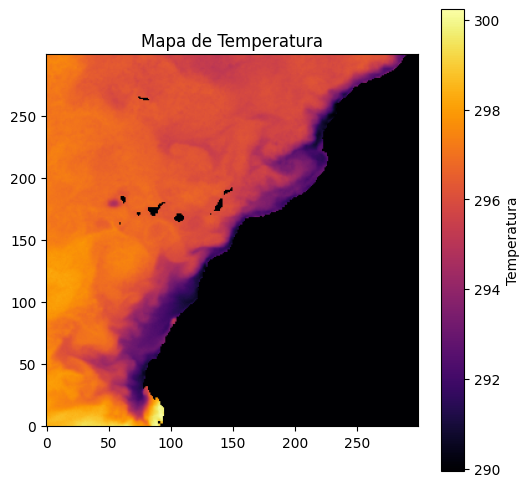

In [52]:
class VotingMechanism:
    def apply(self, data_list):
        pass

class MeanVoting(VotingMechanism):

    def apply(self, data_list):
        return np.mean(data_list, axis=0)

# Ejemplo de uso
data_list = [simplex_noise_list[0], perlin_noise_list[0], np.squeeze(gaussian_noise_list[0])]
votation_mechanism = MeanVoting()
mean_data = votation_mechanism.apply(data_list)

mean_data_2d = flatten_to_2d(mean_data, mask)
plot_temperature_map(mean_data_2d)

### Votación mediana

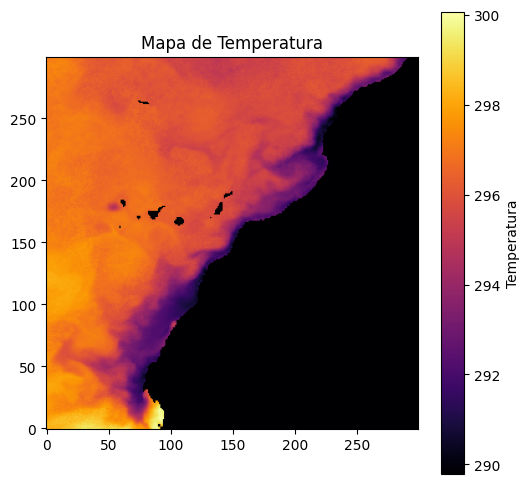

In [53]:
class MedianVoting(VotingMechanism):

    def apply(self, data_list):
        return np.median(data_list, axis=0)

# Ejemplo de uso
data_list = [simplex_noise_list[0], perlin_noise_list[0], np.squeeze(gaussian_noise_list[0])]
votation_mechanism = MedianVoting()
median_data = votation_mechanism.apply(data_list)

median_data_2d = flatten_to_2d(median_data, mask)
plot_temperature_map(median_data_2d)

### Votación ponderada

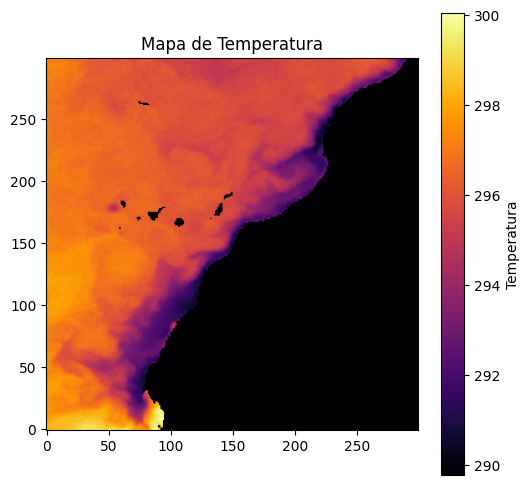

In [54]:
from sklearn.metrics import mean_squared_error

class WeightVoting(VotingMechanism):

    def __init__(self, original_data):
        self.original_data = original_data

    def apply(self, data_list, error_metric=mean_squared_error):
        rmses = [mean_squared_error(self.original_data, data) for data in data_list]

        weights = [1 / rmse for rmse in rmses]
        sum_weights = sum(weights)
        weights_normalized = [w / sum_weights for w in weights]

        data_list_weighted = [data * weight for data, weight in zip(data_list, weights_normalized)]
        weighted_mean = np.sum(data_list_weighted, axis=0)

        return weighted_mean

data_list = [simplex_noise_list[0], perlin_noise_list[0], np.squeeze(gaussian_noise_list[0])]
votation_mechanism = WeightVoting(datos[0])
weighted_data = votation_mechanism.apply(data_list)

weighted_data_2d = flatten_to_2d(weighted_data, mask)
plot_temperature_map(weighted_data_2d)
        

### Diferencias entre métodos de votación:

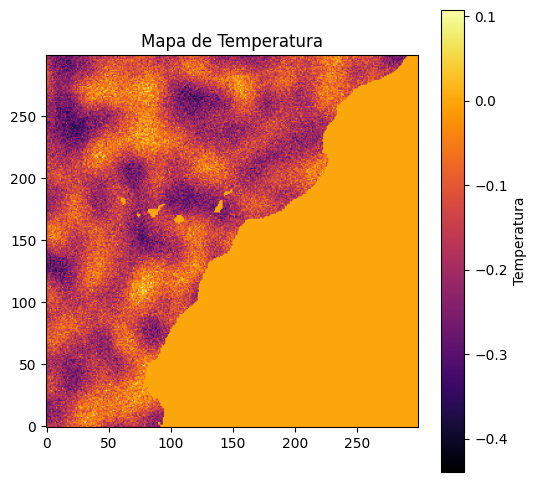

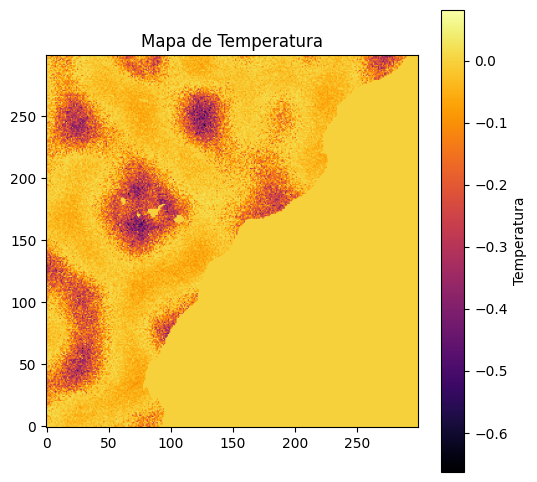

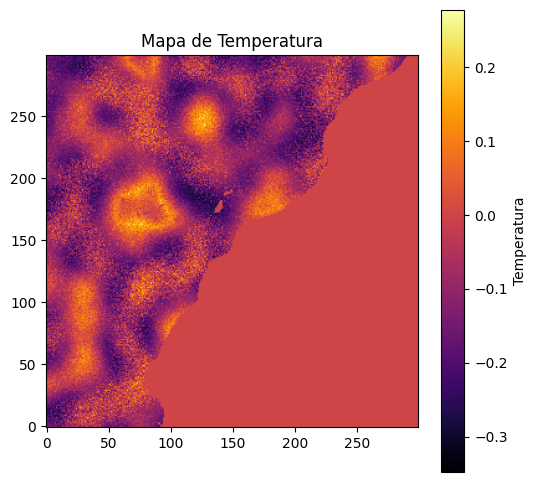

In [55]:

weighted_mean_compared = weighted_data_2d - mean_data_2d
plot_temperature_map(weighted_mean_compared)

weighted_mean_compared = weighted_data_2d - median_data_2d
plot_temperature_map(weighted_mean_compared)

median_mean_compared = median_data_2d - mean_data_2d
plot_temperature_map(median_mean_compared)